# Sreeni U-NET model

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/unet_land_seg/dataset.zip

In [3]:
from keras.utils import normalize
import os
import glob
import cv2

import numpy as np
from matplotlib import pyplot as plt
import random

In [4]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

dataset_path = os.path.join("/content/dataset", "aug")
train_images_path = os.path.join(dataset_path, "train/images")
train_masks_path = os.path.join(dataset_path, "train/masks")

In [ ]:
!ls /content/dataset/aug/train/images


## Load data

In [6]:
import glob
import cv2
import numpy as np

# Capture training image info as a sorted list
train_images = []
image_paths = sorted(glob.glob(os.path.join(train_images_path, "*.tif")))  # ✅ Sort images

for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    train_images.append(img)

train_images = np.array(train_images)

# Capture mask/label info as a sorted list
train_masks = []
mask_paths = sorted(glob.glob(os.path.join(train_masks_path, "*.png")))  # ✅ Sort masks

for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Read mask as a color image
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Invert because of OpenCV
    train_masks.append(mask)

train_masks = np.array(train_masks)

# Debugging: Print first 5 paths to check alignment
print("First 5 Image Paths:", image_paths[:5])
print("First 5 Mask Paths:", mask_paths[:5])

# Shape check
print("Train Images Shape:", train_images.shape)  # Expected: (num_samples, height, width, channels)
print("Train Masks Shape:", train_masks.shape)  # Expected: (num_samples, height, width, channels)


First 5 Image Paths: ['/content/dataset/aug/train/images/HL1.tif_patch_100_49.tif', '/content/dataset/aug/train/images/HL1.tif_patch_100_54.tif', '/content/dataset/aug/train/images/HL1.tif_patch_101_49.tif', '/content/dataset/aug/train/images/HL1.tif_patch_101_52.tif', '/content/dataset/aug/train/images/HL1.tif_patch_101_55.tif']
First 5 Mask Paths: ['/content/dataset/aug/train/masks/HL1.png_patch_100_49.png', '/content/dataset/aug/train/masks/HL1.png_patch_100_54.png', '/content/dataset/aug/train/masks/HL1.png_patch_101_49.png', '/content/dataset/aug/train/masks/HL1.png_patch_101_52.png', '/content/dataset/aug/train/masks/HL1.png_patch_101_55.png']
Train Images Shape: (1446, 256, 256, 3)
Train Masks Shape: (1446, 256, 256, 3)


### Encode labels

In [60]:
# Define a mapping from RGB colors to class labels
COLOR_MAP = {
    (0, 0, 0): 0,        # Black → Background (Class 0)
    (128, 128, 128): 1,  # Gray → Roads (Class 1)
    (255, 0, 0): 2       # Red → Rodents (Class 2)
}
def encode_mask(mask):
    """ Convert RGB mask to class indices """
    h, w, _ = mask.shape
    encoded_mask = np.zeros((h, w), dtype=np.uint8)  # Create an empty mask

    for rgb, class_id in COLOR_MAP.items():
        encoded_mask[np.all(mask == rgb, axis=-1)] = class_id  # Assign class label

    return encoded_mask

train_masks_encoded = np.array([encode_mask(mask) for mask in train_masks])
print("Unique Values in Encoded Mask:", np.unique(train_masks_encoded))

Unique Values in Encoded Mask: [0 1 2]


In [63]:
def decode_mask(mask):
    """
    Convert a class-index mask to an RGB image for visualization.

    Args:
        mask (numpy array): A 2D array with class labels (H, W)

    Returns:
        numpy array: An (H, W, 3) RGB image
    """
    h, w = mask.shape  # Get height & width
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)  # Initialize RGB mask

    # Assign RGB colors correctly using broadcasting
    for rgb, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = np.array(rgb, dtype=np.uint8)  # Assign RGB color

    return rgb_mask


## Normalize and set dimensions

In [9]:
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded, axis=3)

print("Train Images Shape:", train_images.shape)  # Expected: (num_samples, height, width, channels)
print("Train Masks Shape:", train_masks_input.shape)  # Expected: (num_samples, height, width, channels)

Train Images Shape: (1446, 256, 256, 3)
Train Masks Shape: (1446, 256, 256, 1)


## Data splits

In [10]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are ...  [0 1 2]


In [11]:
from keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # just to be sure

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes)) # just to be sure

## Class weights

In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Flatten the mask array to 1D
train_masks_flat_encoded = train_masks_encoded.flatten()

# Compute class weights
class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_masks_flat_encoded),
    y=train_masks_flat_encoded
)

print("Class weights are:", class_weights_values)

# Convert to dictionary (required for model.fit)
class_weights = {i: class_weights_values[i] for i in range(len(class_weights_values))}
print("Class Weights:", class_weights)

Class weights are: [0.49150984 3.77707201 1.42714959]
Class Weights: {0: 0.49150984094026895, 1: 3.777072012636334, 2: 1.4271495873565028}


## Model definition

In [13]:
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions

    return model

## Model compilation

In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## Fit model

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test_cat),
                    # class_weight=class_weights,
                    )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6609 - loss: 0.8833

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


130/130 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6609 - loss: 0.8829 - val_accuracy: 0.6773 - val_loss: 0.7705
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.6944 - loss: 0.7451 - val_accuracy: 0.7642 - val_loss: 0.6541
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.7472 - loss: 0.6823 - val_accuracy: 0.7584 - val_loss: 0.6993
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7726 - loss: 0.6396 - val_accuracy: 0.8028 - val_loss: 0.5658
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8026 - loss: 0.5614 - val_accuracy: 0.7714 - val_loss: 0.6288
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7992 - loss: 0.5595 - val_accuracy: 0.8116 - val_loss: 0.5152
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7975 - loss: 0.5426 - val_accuracy: 0.7937 - val_loss: 0.5472
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8166 - loss: 0.4779 - val_accuracy: 0.813

In [19]:
model.save('/content/drive/MyDrive/unet_land_seg/unet_model_multiclass.keras')

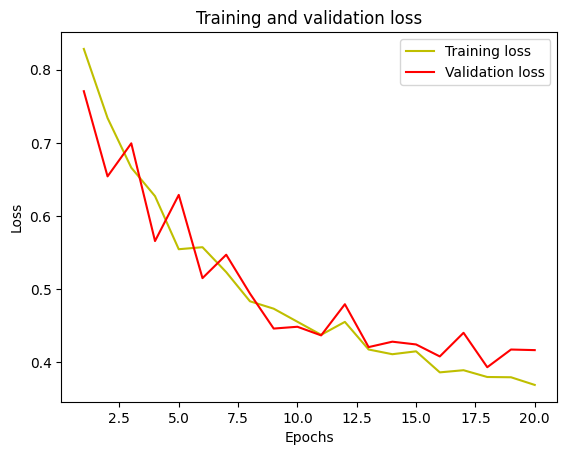

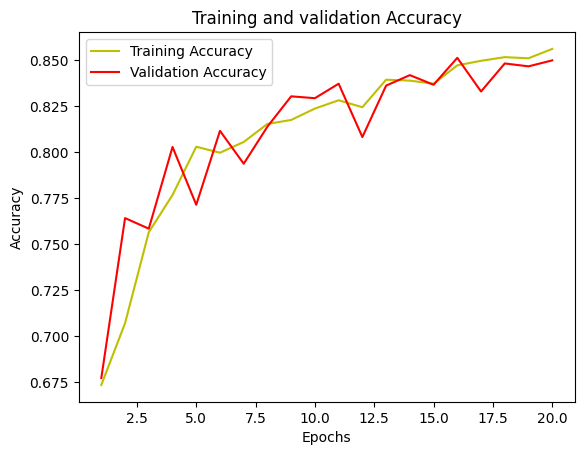

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


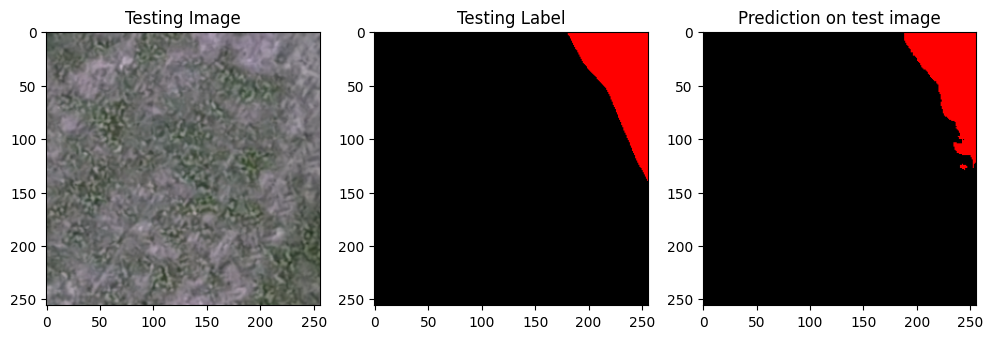

In [92]:

# Randomly select a test image
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]  # Get test image

ground_truth = y_test[test_img_number]  # Get ground truth mask
ground_truth = np.squeeze(ground_truth, axis=-1)

test_img_input = np.expand_dims(test_img, axis=0)  # Add batch dimension

# Predict segmentation mask
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)  # Convert softmax to class labels
predicted_img = predicted_img.squeeze(0)  # Now shape is (256, 256)

# Convert ground truth and prediction to RGB (if needed)
ground_truth_rgb = decode_mask(ground_truth)  # Convert label mask to RGB
predicted_rgb = decode_mask(predicted_img)

# # Plot results
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow((test_img * 255*7).astype(np.uint8))  # Show original image

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_rgb)  # Show true segmentation mask in RGB

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_rgb)  # Show predicted segmentation mask in RGB

# plt.show()